In [56]:
from sdtoolbox.postshock import CJspeed, PostShock_fr
from sdtoolbox.znd import zndsolve
from sdtoolbox.utilities import CJspeed_plot, znd_plot, znd_fileout
import cantera as ct
import numpy as np
import csv

In [57]:
gas = ct.Solution("FFCM2_H2_Ar.yaml")
print(gas.species_names)
gas.set_equivalence_ratio(1.0,fuel="H2", oxidizer="O2:1, AR:7")
gas.TP = 298, 6670
print(gas.Y)

['H', 'H2', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'AR']
[0.         0.01277243 0.         0.10136214 0.         0.
 0.         0.         0.88586543]


In [58]:
P1 = 6670.0
T1 = 298
q = 'H2:0.2,O2:0.1,AR:0.7'
mech = 'FFCM2_H2_Ar.yaml'
file_name = 'ffcm2hydrogen'

In [59]:
cj_speed,R2,plot_data = CJspeed(P1,T1,q,mech,fullOutput=True)
#CJspeed_plot(plot_data,cj_speed)
print(cj_speed)

1615.8858332757773


In [60]:
gas1 = ct.Solution(mech)
gas1.TPX = T1,P1,q
gas1()
phi = gas1.equivalence_ratio(fuel="H2",
                            oxidizer="O2:1,AR:7")
print("phi = ", phi)
gas = PostShock_fr(cj_speed, P1, T1, q, mech)


  gas:

       temperature   298 K
          pressure   6670 Pa
           density   0.084981 kg/m^3
  mean mol. weight   31.568 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy            -110.5           -3488.3  J
   internal energy            -78599       -2.4812e+06  J
           entropy            5838.8        1.8432e+05  J/K
    Gibbs function       -1.7401e+06       -5.4931e+07  J
 heat capacity c_p            736.67             23255  J/K
 heat capacity c_v            473.28             14941  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2          0.012772               0.2           -20.047
                O2           0.10136               0.1           -29.697
                AR           0.88587               0.7           -21.701
     [

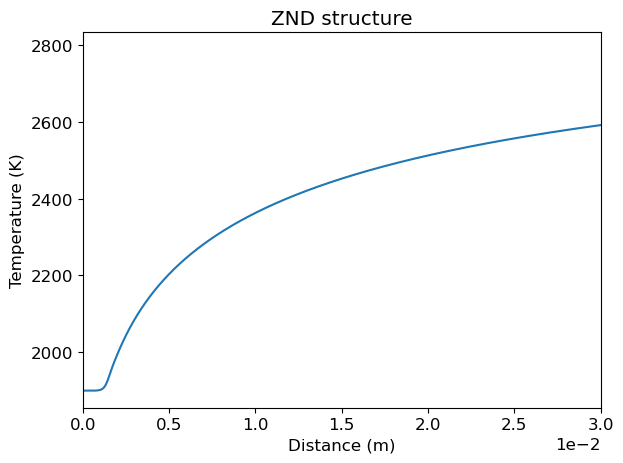

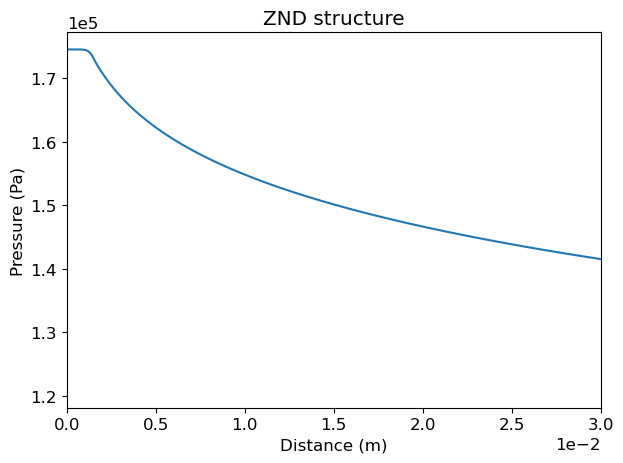

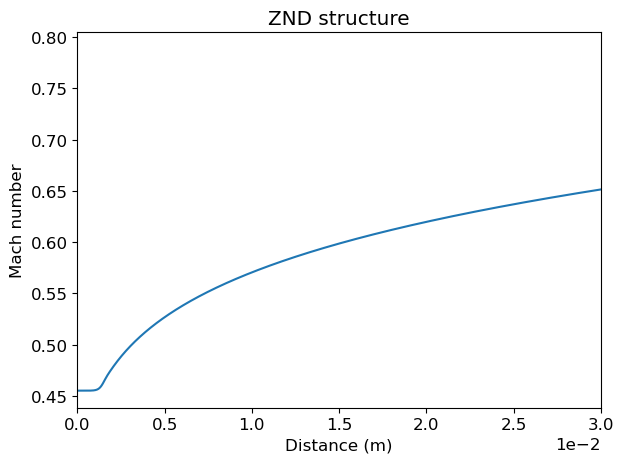

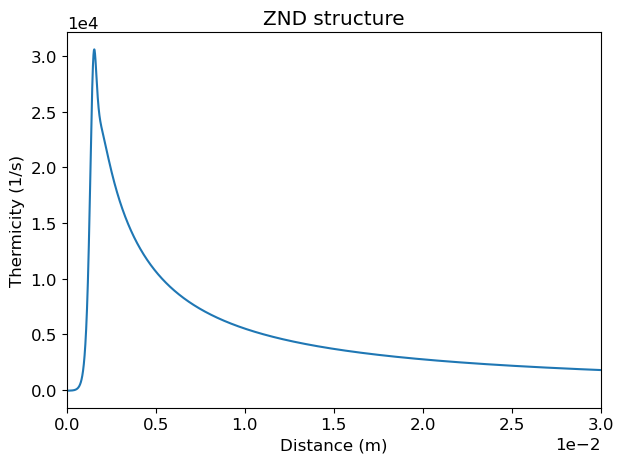

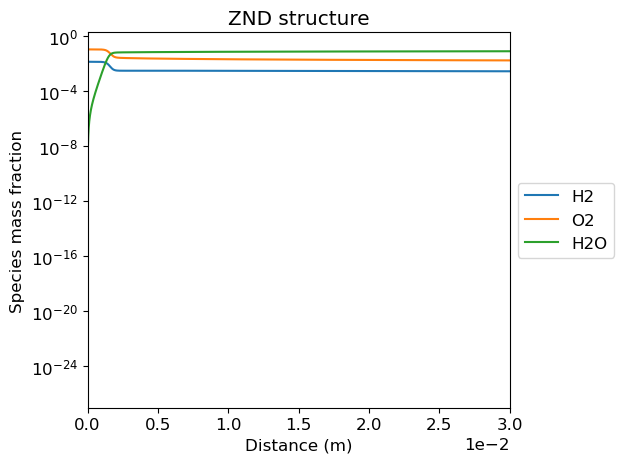

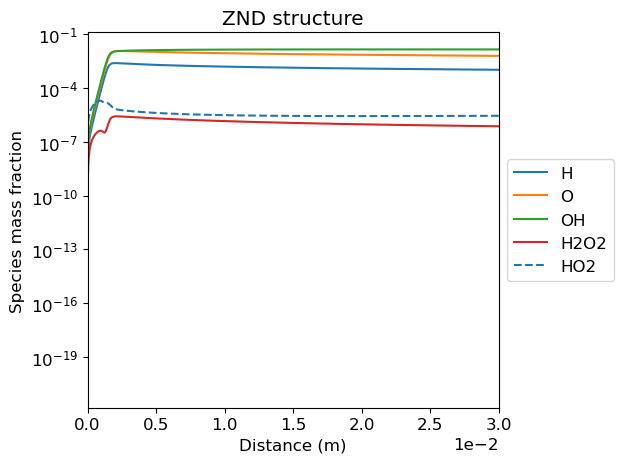

Reaction zone pulse width (exothermic length) = 0.002082 m
Reaction zone induction length = 0.001544 m
Reaction zone pulse time (exothermic time) = 4.866e-06 s
Reaction zone induction time = 3.905e-06 s


In [61]:
# Solve ZND ODEs, make ZND plots
znd_out = zndsolve(gas,gas1,cj_speed,t_end=1e-3,advanced_output=True,Method='BDF',relTol=1e-20,absTol=1e-18)
# znd_out = zndsolve(gas,gas1,cj_speed,t_end=1e-3,advanced_output=True,Method='BDF')#,relTol=5e-14,absTol=1e-20)
# znd_out = zndsolve(gas,gas1,cj_speed,t_end=1e-5,advanced_output=True,Method='BDF',relTol=5e-14,absTol=1e-20)
# znd_out = zndsolve(gas,gas1,cj_speed,t_end=1e-5,advanced_output=True,Method='LSODA',relTol=5e-14,absTol=1e-20)
znd_plot(znd_out, maxx=30e-3, 
        major_species=['H2', 'O2', 'H2O'],
        minor_species=['H', 'O', 'OH','H2O2','HO2']
        )
         

print('Reaction zone pulse width (exothermic length) = %.4g m' % znd_out['exo_len_ZND'])
print('Reaction zone induction length = %.4g m' % znd_out['ind_len_ZND'])
print('Reaction zone pulse time (exothermic time) = %.4g s' % znd_out['exo_time_ZND'])
print('Reaction zone induction time = %.4g s' % znd_out['ind_time_ZND'])

In [17]:
species_names_array = znd_out['gas1'].species_names
n_species = len(species_names_array)
n_cols = 4+1+n_species #pressure, density, temperature, velocity, X (additional 5 variables)
header = ['X','Pressure', 'Temperature', 'Density','Velocity'] + species_names_array

# extract distance from solution 
x_array = znd_out['distance']
x_array = np.transpose(x_array)

#extract pressure from solution
p_array = znd_out['P']
p_array = np.transpose(p_array)

#extract temperature from solution
T_array = znd_out['T']
T_array = np.transpose(T_array)

#extract density from solution
rho_array = znd_out['rho']
rho_array = np.transpose(rho_array)

#extract density from solution
vel_array = znd_out['U']
vel_array = np.transpose(vel_array)

#extract species from solution
species_array = znd_out['species'].T

#create output array
out_array = np.zeros((len(x_array),n_cols))

#stack things up here
out_array[:,0] = x_array
out_array[:,1] = p_array
out_array[:,2] = T_array
out_array[:,3] = rho_array
out_array[:,4] = vel_array
out_array[:,5:] = species_array
with open(file_name+'_ZND_solution.csv', 'w') as f:
# with open(file_name+'_'+str(cj_speed)+'overdriven_zndshk_solution.txt', 'w') as f:
    f.write('VARIABLES = ')
    for name in header:
        f.write('"%s" '%name)
    f.write('\n')
with open(file_name+'_ZND_solution.csv', 'a') as f:
# with open(file_name+'_'+str(cj_speed)+'overdriven_zndshk_solution.txt', 'a') as f:
    csv.writer(f, delimiter=' ').writerows(out_array)

/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_19709/4107373079.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  znd_data = pd.read_csv('ffcm2hydrogen_ZND_solution.csv', delim_whitespace=True)


(7730, 14)
0
[[1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 0.00000000e+00
  0.00000000e+00 8.85865433e-01]
 [1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 5.09446219e-13
  1.31967592e-21 8.85865433e-01]
 [1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 1.01889244e-12
  4.16505295e-21 8.85865433e-01]
 ...
 [1.20856538e+05 2.78878550e+03 1.75074783e-01 ... 4.08462858e-06
  3.17141772e-07 8.85865433e-01]
 [1.20856538e+05 2.78878550e+03 1.75074783e-01 ... 4.08462858e-06
  3.17141772e-07 8.85865433e-01]
 [1.20856538e+05 2.78878550e+03 1.75074783e-01 ... 4.08462858e-06
  3.17141772e-07 8.85865433e-01]]
(8000, 14)
1
[[1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 0.00000000e+00
  0.00000000e+00 8.85865433e-01]
 [1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 5.09446219e-13
  1.31967592e-21 8.85865433e-01]
 [1.74483043e+05 1.89993165e+03 3.48680880e-01 ... 1.01889244e-12
  4.16505295e-21 8.85865433e-01]
 ...
 [1.20856538e+05 2.78878550e+03 1.75074783e-01 ... 4.08462858e-06
  3.17

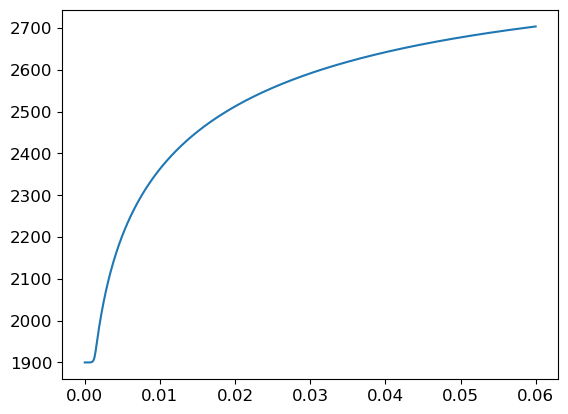

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

openfoam_data = pd.read_csv('consolidated_with_xy.csv')
znd_data = pd.read_csv('ffcm2hydrogen_ZND_solution.csv', delim_whitespace=True)
znd_data = znd_data.sort_values(by=znd_data.columns[0])
print(znd_data.shape)
#First add two columns to openfoam data to house V and density
openfoam_data['T'] = 0.0
openfoam_data['P'] = 0.0
openfoam_data['H'] = 0.0
openfoam_data['H2'] = 0.0
openfoam_data['O'] = 0.0
openfoam_data['O2'] = 0.0
openfoam_data['OH'] = 0.0
openfoam_data['H2O'] = 0.0
openfoam_data['HO2'] = 0.0
openfoam_data['H2O2'] = 0.0
openfoam_data['Ar'] = 0.0
openfoam_data['Vx'] = 0.0

x_test = np.linspace(0,0.06,1000)
x_for_interp_from_znd = znd_data.iloc[:, 0].values 
other_data_from_znd = znd_data.iloc[:, 1:].values
spline = CubicSpline(x_for_interp_from_znd, other_data_from_znd[:, 1])

plt.plot(x_test, spline(x_test))

for index, row in openfoam_data.iterrows():
    print(index)
    x_cell = row.iloc[0]
    y_cell = row.iloc[1]
    x_front = 0.005*np.sin(4*np.pi*y_cell/0.06) + 0.05   #CHANGE VALUES HERE TO CHANGE SINUSIODAL WAVE 

    interpolated_row = np.array([])
    if  x_cell < x_front:
        distance_behind = x_front - x_cell
        #Cubic Spline Interpolation
        x_for_interp_from_znd = znd_data.iloc[:, 0].values 
        other_data_from_znd = znd_data.iloc[:, 1:].values  
        interpolated_values = []
        for col in range(other_data_from_znd.shape[1]):
            spline = CubicSpline(x_for_interp_from_znd, other_data_from_znd[:, col])
            interpolated_values.append(spline(distance_behind)) 
        interpolated_row = [x_cell] + interpolated_values 

    else:
        #Initial Conditions
        #VARIABLES = "X" "Pressure" "Temperature" "Density" "Velocity" "H" "H2" "O" "O2" "OH" "H2O" "HO2" "H2O2" "AR" (confirmed same order in openfoam: #Order: "H", "H2", "O", "O2", "OH", "H2O", "HO2", "H2O2", "AR")
        interpolated_row = np.array([x_cell, 6670, 298, 0.084981, 0.0, 0.0, 0.01277243, 0.0, 0.10136214, 0.0, 0.0, 0.0, 0.0, 0.88586543])

    openfoam_data.at[index, openfoam_data.columns[3]] = interpolated_row[1] #press
    openfoam_data.at[index, openfoam_data.columns[2]] = interpolated_row[2] #temp
    openfoam_data.at[index, openfoam_data.columns[4]] = interpolated_row[5] #H
    openfoam_data.at[index, openfoam_data.columns[5]] = interpolated_row[6] #H2
    openfoam_data.at[index, openfoam_data.columns[6]] = interpolated_row[7] #O
    openfoam_data.at[index, openfoam_data.columns[7]] = interpolated_row[8] #O2
    openfoam_data.at[index, openfoam_data.columns[8]] = interpolated_row[9] #OH
    openfoam_data.at[index, openfoam_data.columns[9]] = interpolated_row[10] #H2O
    openfoam_data.at[index, openfoam_data.columns[10]] = interpolated_row[11] #HO2
    openfoam_data.at[index, openfoam_data.columns[11]] = interpolated_row[12] #H2O2
    openfoam_data.at[index, openfoam_data.columns[12]] = interpolated_row[13] #Ar
    openfoam_data.at[index, openfoam_data.columns[13]] = interpolated_row[4] #Velocity
    print(openfoam_data.shape)

openfoam_data.to_csv('initialization_for_openfoam.csv', index=False)


0       2472.231779
1       2467.953277
2       2463.572289
3       2459.084479
4       2454.485235
           ...     
7995     298.000000
7996     298.000000
7997     298.000000
7998     298.000000
7999     298.000000
Name: T, Length: 8000, dtype: float64


/var/folders/n_/rcf8wz2n2dn4lpt0vg476ky00000gn/T/ipykernel_19709/3364597763.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 3 Axes> than <Figure size 1000x600 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, label='Temperature (T)')


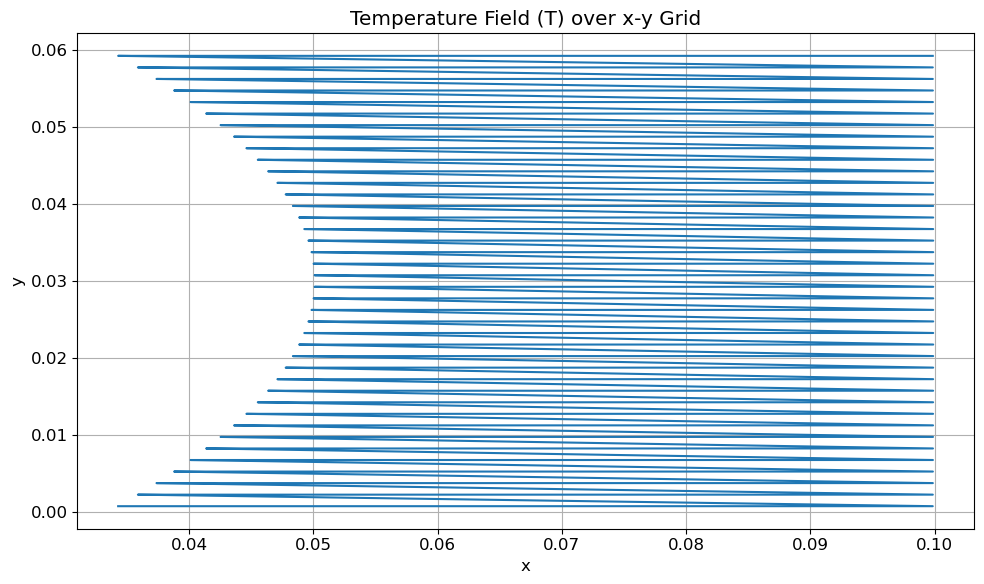

In [88]:

# Load the output CSV
data = pd.read_csv("initialization_for_openfoam.csv")

# Extract x, y, T columns (assuming T is in column index 2)
x = data.iloc[:, 0]
y = data.iloc[:, 1]
T = data.iloc[:, 2]
print(T)
# Plot using a scatter plot with color mapping for temperature
plt.figure(figsize=(10, 6))
plt.plot(x,y)
#sc = plt.scatter(x, y, c=T, cmap='inferno', s=1)
plt.colorbar(sc, label='Temperature (T)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Field (T) over x-y Grid')
plt.grid(True)
plt.tight_layout()
plt.show()